In [191]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#분위수 기준 클러스터링
parks_df = pd.read_csv("RF_parksdf.csv")
parks_df.columns

parks_df["complaints_r300"].quantile(q=0.25) #788
parks_df["complaints_r300"].quantile(q=0.5) #1441
parks_df["complaints_r300"].quantile(q=0.75) #2816
#parks_df.loc[parks_df["complaints_r300"]>=10000]

parks_df["complaint_level"] = pd.qcut(
    parks_df["complaints_r300"],  # 민원 건수 열
    q=4,                          # 분위수: 4분위 (quartile) → 낮음/중간이하/중간이상/높음
    labels=["낮음", "중간이하", "중간이상", "높음"]
)
parks_df["complaint_level"].value_counts()

complaint_level
낮음      353
중간이상    352
중간이하    350
높음      350
Name: count, dtype: int64

In [ ]:
#자연발생 클러스터링(민원 단계 컬럼 생성)
from jenkspy import JenksNaturalBreaks

parks_df = pd.read_csv("RF_parksdf.csv")
parks_df.columns

i = 3

breaks = JenksNaturalBreaks(n_classes=i)
breaks.fit(parks_df["complaints_r300"])
print(breaks.breaks_)  # 구간 경계

parks_df["complaint_level"] = pd.cut(
    parks_df["complaints_r300"], bins=breaks.breaks_, labels=range(i), include_lowest=True
)
parks_df["complaint_level"].value_counts()

[0, 2761, 8353, 36939]


complaint_level
0    1044
1     311
2      50
Name: count, dtype: int64

In [ ]:
#범주형 변수의 label을 [0,1]로 변환
from sklearn.preprocessing import LabelEncoder

le_dict = {}
for col in ["parking_type", "operation_type", "Weekday_paid", "Saturday_paid", "Holiday_paid"]:
    le = LabelEncoder()
    parks_df[col] = le.fit_transform(parks_df[col])
    le_dict[col] = le  # 변수별로 인코더 저장

# 예시: parking_type의 범주와 정수 매핑 확인
print(list(le_dict["parking_type"].classes_))
print(list(le_dict["operation_type"].classes_))
print(list(le_dict["Weekday_paid"].classes_))
print(list(le_dict["Saturday_paid"].classes_))
print(list(le_dict["Holiday_paid"].classes_))
# [0, 1, 2, ...] 순서로 classes_에 저장됨
#['NS', 'NW'] -> [0,1]
#[1, 3] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]

['NS', 'NW']
[1, 3]
['N', 'Y']
['N', 'Y']
['N', 'Y']


In [218]:
X = parks_df.drop(["complaints_r300","address",'Unnamed: 0'], axis=1)
y = parks_df["complaint_level"]

# 추가 변수 삭제
#X_new= X.drop(["Weekday_paid", "parking_type",],axis = 1)


X_new = X[["bus_r300", "total_parking_spaces","cctv_r300", 
           "fee1H","base_parking_fee", "additional_unit_fee", "Weekday_operatingHours",
            "Weekday_end", "additional_unit_time","Saturday_operatingHours",
            "Saturday_end"]]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)

X_new.columns

Index(['bus_r300', 'total_parking_spaces', 'cctv_r300', 'fee1H',
       'base_parking_fee', 'additional_unit_fee', 'Weekday_operatingHours',
       'Weekday_end', 'additional_unit_time', 'Saturday_operatingHours',
       'Saturday_end'],
      dtype='object')

In [ ]:
#robust scalar 적용 cell인데 효과 없음
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale

transformer = RobustScaler()
X_robust = transformer.fit_transform(X_new)
X_robust = robust_scale(X_robust)

X_train, X_test, y_train, y_test = train_test_split(X_robust, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)

In [ ]:
# 랜덤포레스트 
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.8298


In [ ]:
# 변수 중요도 표
importances = rf.feature_importances_
names = rf.feature_names_in_

table = pd.DataFrame(names,importances)
table

,0
0.169592,bus_r300
0.200985,total_parking_spaces
0.144255,cctv_r300
0.096431,fee1H
0.084137,base_parking_fee
0.068921,additional_unit_fee
0.050723,Weekday_operatingHours
0.073047,Weekday_end
0.020626,additional_unit_time
0.046367,Saturday_operatingHours


In [226]:
from sklearn.metrics import mean_squared_error

val_predict = rf.predict(X_val)
val_predict

test_predict = rf.predict(X_test)

mean_squared_error(y_test, val_predict)

0.41843971631205673

In [223]:
#최적 하이퍼 파라미터를 찾았는데 기존 모델보다 성능 낮아짐..
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [500, 1000],
           'max_depth' : [6, 8, 10],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [3, 5]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 1000}
최고 예측 정확도: 0.7498


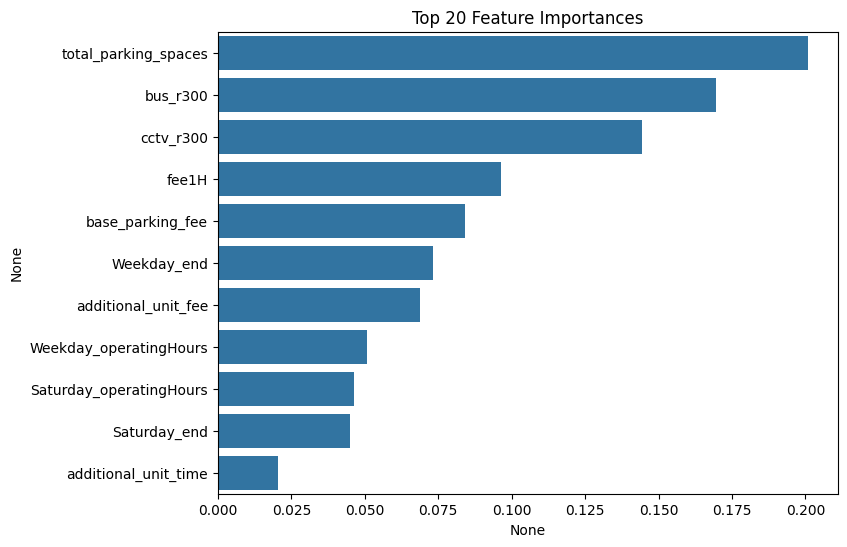

In [ ]:
# 변수 중요도 플로팅
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_new.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
# train data
X_new.head

<bound method NDFrame.head of       bus_r300  total_parking_spaces  cctv_r300  fee1H  base_parking_fee  \
0            1                   132          0   2400               200   
1            1                    97          0   2400               200   
2            5                   194          3   2400               200   
3            4                   168          2   1200               100   
4            7                   149          2   2400               200   
...        ...                   ...        ...    ...               ...   
1400         8                   130          3   1200               100   
1401        17                     4          1   3000               250   
1402         6                     1          2   1200               100   
1403         5                     1          1    600               600   
1404         7                     1          4    600               600   

      additional_unit_fee  Weekday_operatingHours  Weekda